In [1]:
%matplotlib inline

import math

import cv2
import dlib

import numpy as np
import matplotlib.pyplot as plt

import multiprocessing as mp
import sys
import os
import time
from itertools import product

plt.rcParams["figure.figsize"] = [12, 8]

In [2]:
class Landmarker(object):
    
    def __init__(self, dlib_shape_model_path = None):
        
        if dlib_shape_model_path is None:
            dlib_shape_model_path = "/Users/yc/git/HeadGen/dev/data/shape_predictor_68_face_landmarks.dat"
        self._shape_predictor = dlib.shape_predictor(dlib_shape_model_path)
        self._face_detector = dlib.get_frontal_face_detector()
    
    def generateShapes(self, image):        
        rects = self._face_detector(image)
        shapes = [None for _ in range(len(rects))]
        for i, rect in enumerate(rects):
            shape = self._shape_predictor(image,rect)
            shapes[i] = self._fullobj2array(shape)
        
        return shapes
    
    def _fullobj2array(self, full_obj):
        landmarks = np.zeros((full_obj.num_parts, 2), dtype=np.int)
        for i in range(full_obj.num_parts):
            part = full_obj.part(i)
            landmarks[i, 0] = part.x
            landmarks[i, 1] = part.y
        
        return landmarks

In [3]:
landmarker = Landmarker()

# image_name = '-421000000182_photo' #其實亮暗還算平均
# image_name = '-421000000230_photo' #其實亮暗還算平均
# image_name = '-421000000283_photo' #中間暗旁邊亮
# image_name = '-421000000301_photo' #其實亮暗還算平均
image_name = '-421000000315_photo' #半亮
# image_name = '-421000000343_photo' #半亮
# image_name = '-421000000365_photo' #半亮

image = cv2.imread('/Users/yc/Downloads/samples/' + image_name + '.jpg', cv2.IMREAD_COLOR)
image_After = cv2.imread('/Users/yc/Downloads/samples/' + image_name + '_After.jpg', cv2.IMREAD_COLOR)
shapes = landmarker.generateShapes(image)
#shapes[0][:10]

In [4]:
def plot_landmarks(image, landmarks, color=(255,0,0), font_color=(0,0,255)):
    radius = int(0.005*np.mean(image.shape[:2]))
    font_thickness = int(0.6*radius)
    for i, row in enumerate(landmarks):
        x, y = map(int, row)
        cv2.circle(image, (x,y), radius, color, -1)
        cv2.putText(image, str(i), (x+3,y-3), cv2.FONT_HERSHEY_SIMPLEX, 0.3, font_color, font_thickness)

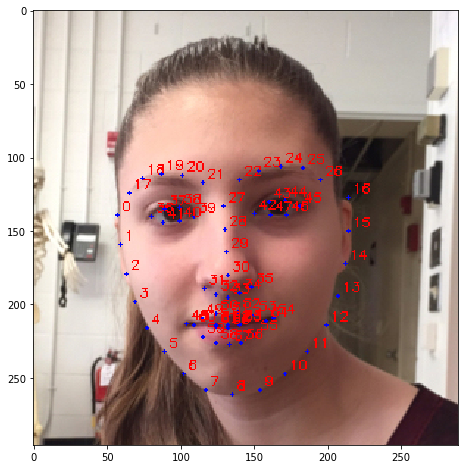

In [5]:
marked_image = image.copy()
plot_landmarks(marked_image, shapes[0])

plt.imshow(cv2.cvtColor(marked_image, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
#參考用距離
right_eye_height = abs(shapes[0][38][1] - shapes[0][41][1])
left_eye_height = abs(shapes[0][43][1] - shapes[0][46][1])
eye_height = (right_eye_height + left_eye_height) / 2
eyes_gap = abs(shapes[0][39][0] - shapes[0][42][0])

points = []
right_forehead = shapes[0][19] + np.array([0, -1.5 * eye_height])
points.append(right_forehead.astype(np.int))

left_forehead = shapes[0][24] + np.array([0, -1.5 * eye_height])
points.append(left_forehead.astype(np.int))

mid_forehead = (shapes[0][19] + shapes[0][24]) / 2 - np.array([0, eye_height])
points.append(mid_forehead.astype(np.int))

right_eye_top = (shapes[0][21] + shapes[0][39]) / 2
points.append(right_eye_top.astype(np.int))

left_eye_top = (shapes[0][22] + shapes[0][42]) / 2
points.append(left_eye_top.astype(np.int))

right_eye_bottom = shapes[0][41] + np.array([0, eye_height])
points.append(right_eye_bottom.astype(np.int))

left_eye_bottom = shapes[0][46] + np.array([0, eye_height])
points.append(left_eye_bottom.astype(np.int))

right_nose = shapes[0][29] + np.array([-0.5 * eyes_gap, 0])
points.append(right_nose.astype(np.int))

left_nose = shapes[0][29] + np.array([0.5 * eyes_gap, 0])
points.append(left_nose.astype(np.int))

mid_nose = shapes[0][30]
points.append(mid_nose.astype(np.int))

right_face = shapes[0][3] + np.array([0.5 * eyes_gap, 0])
points.append(right_face.astype(np.int))

left_face = shapes[0][13] + np.array([-0.5 * eyes_gap, 0])
points.append(left_face.astype(np.int))

bottom_face = shapes[0][8] + np.array([0, -1.0 * eye_height])
points.append(bottom_face.astype(np.int))

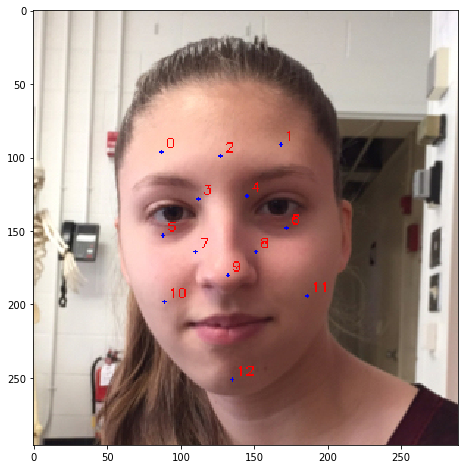

In [7]:
marked_image = image.copy()
plot_landmarks(marked_image, points)

plt.imshow(cv2.cvtColor(marked_image, cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
image_RGB_f = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float)
image_HSV_f = cv2.cvtColor(image, cv2.COLOR_BGR2HSV).astype(np.float)

In [9]:
print(image.shape)

colors = []
for point in points:
    color = image_HSV_f[point[1], point[0], :]
    colors.append(color)
    print(point[1], point[0], color)

(296, 289, 3)
96 87 [   9.   67.  255.]
91 168 [   7.  107.  190.]
99 127 [   6.   88.  231.]
128 112 [   2.   78.  169.]
126 145 [   4.  124.   97.]
153 88 [   0.   83.  187.]
148 172 [   5.  129.  115.]
164 110 [   2.   63.  253.]
164 151 [   2.  109.  148.]
180 132 [   2.   96.  223.]
198 89 [   2.   67.  209.]
194 186 [   5.  121.  124.]
251 135 [   4.  116.  112.]


In [10]:
def findMask_one_ps(image, sigma_color, color):
    '''
    依照 h s v 計算距離 輸出 0~1 代表與color相似度
    '''
    
    distance = np.abs(image - color)
    normalize = distance * np.array([1.0 / 180, 1.0 / 255, 1.0 / 255], dtype=np.float)
    
    weights = np.array([20.0, 5.0, 1.0], dtype=np.float)
    nor = np.sum(normalize * weights, axis = 2) / np.sum(weights)
    return 1 - nor

def findMask(image, sigma_color, colors):
    '''
    params
    ======
    - image: image bitmap
    - sigma_color: color space threshold
    - colors: reference colors
    
    returns
    =======
    - mask: mask of selected pixels in [0, 1]
    '''
    mask_all = None
    for color in colors:
        
        #mask = cv2.inRange(image, color - sigma_color, color + sigma_color)
        mask = findMask_one_ps(image, sigma_color, color)
        
        if mask_all is None:
            mask_all = mask
        else:
            mask_all = cv2.max(mask, mask_all)
        
    return mask_all

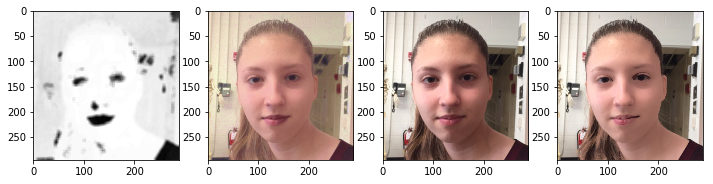

In [11]:
# [5, 30, 30] 特殊顏色
mask = findMask(image_HSV_f, colors[2], colors)
mask *= 0.4
mask = cv2.blur(mask, (7, 7))

# plt.hist(mask.flatten(), bins=100)
# plt.show()

target = colors[2] #額頭中間的顏色
ret_image = image_HSV_f.copy()
ret_image[:,:,1] = mask * target[1] + (1 - mask) * ret_image[:,:,1]
ret_image[:,:,2] = mask * target[2] + (1 - mask) * ret_image[:,:,2]   
ret_image = cv2.cvtColor(ret_image.astype(np.uint8), cv2.COLOR_HSV2RGB)

# target = cv2.cvtColor((np.zeros([10, 10, 3]) + colors[2]).astype(np.uint8), cv2.COLOR_HSV2RGB)
# plt.imshow(target)
# plt.show()

# target= target.astype(np.float)[0, 0]
# ret_image = image_RGB_f.copy()
# ret_image[:,:,0] = mask * target[0] + (1 - mask) * ret_image[:,:,0]
# ret_image[:,:,1] = mask * target[1] + (1 - mask) * ret_image[:,:,1]
# ret_image[:,:,2] = mask * target[2] + (1 - mask) * ret_image[:,:,2]

number = 4
plt.subplot(1, number, 1); plt.imshow((mask * 255).astype(np.uint8), cmap='gray', interpolation=None)
plt.subplot(1, number, 2); plt.imshow(ret_image.astype(np.uint8))
plt.subplot(1, number, 3); plt.imshow(image_RGB_f.astype(np.uint8))
plt.subplot(1, number, 4); plt.imshow(cv2.cvtColor(image_After, cv2.COLOR_BGR2RGB))
plt.show()

In [12]:
#temp_img = cv2.cvtColor(ret_image.astype(np.uint8), cv2.COLOR_RGB2BGR)
#cv2.imwrite("/Users/yc/Desktop/test.png", temp_img)